In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
N_COLLOCATION_POINTS_X = 100
N_COLLOCATION_POINTS_T = 100
LEARNING_RATE = 1e-3
N_OPTIMIZATION_EPOCHS = 1000

X = [-1, 1]
T = [0, 1]

In [71]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, output_transform=None):
        super().__init__()
        self.activation = activation
        # output_transform should be of the form: 
        # output_transorm(u(x, y), x, y)
        self.output_transform = output_transform
        self.linears = torch.nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(
                torch.nn.Linear(
                    layer_sizes[i - 1], layer_sizes[i]
                )
            )

    def forward(self, x, y=None, z=None):
        if y is not None:
            if z is not None:
                act = torch.cat([x, y, z], dim=1)
            else:
                act = torch.cat([x, y], dim=1)
        else:
            act = x
            
        for linear in self.linears[:-1]:
            act = self.activation(linear(act))
        act = self.linears[-1](act)
        
        # act = u(x, y)
        if self.output_transform is not None:
            act = self.output_transform(act, x, y)
        return act

In [78]:
pinn = MLP([1, 32, 32, 32, 1], nn.functional.tanh)

In [79]:
x_ = torch.rand(2,1)
y_ = torch.rand(2,1)
z_ = torch.rand(2,1)
pinn(x_)

tensor([[-0.0051],
        [ 0.0358]], grad_fn=<AddmmBackward0>)

In [165]:
def grad(net, inps, ind, deg):
    inps[ind] = inps[ind].requires_grad_(True)
    u = net(*inps)
    for _ in range(deg):
        u = torch.autograd.grad(u, inps[ind], grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u

In [171]:
def jacobian(net, inps, ind):
    return grad(net, inps, ind, deg=1)

def hessian(net, inps, ind):
    return grad(net, inps, ind, deg=2)

In [181]:
def first_grad_t(net, x, t):
    t = t.requires_grad_(True)
    u = net(x, t)
    # First derivative
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u_t

def second_grad_x(net, x, t):
    x = x.requires_grad_(True)
    u = net(x, t)
    # First derivative
    u_y = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    return u_yy

def pde_residual(net, x, t):
    u_t = jacobian(net, [x, t], ind=1)
    u_xx = hessian(net, [x, t], ind=0)
    return u_t - u_xx + torch.exp(-t) * (torch.sin(torch.pi * x) - torch.pi**2 * torch.sin(torch.pi * x))

In [174]:
x_ = torch.rand(2,1, requires_grad=True)
t_ = torch.rand(2,1, requires_grad=True)
pinn = MLP([2, 32, 32, 32, 1], nn.functional.tanh)
u = pinn(x_, t_)
jacobian(pinn, [x_, t_], 0)

tensor([[0.0990],
        [0.0840]], grad_fn=<SliceBackward0>)

In [175]:
# construction to compute mixed partials
u_x = jacobian(pinn, [x_, t_], ind=0) # first wrt. x
u_xt = jacobian(pinn, [u_x, t_], ind=1) # then wrt. t

In [182]:
def hard_condition(u, x, t):
    # enforces initial and boundary condition
    # u = net(x, t)
    return t * (1 - x**2) * u + torch.sin(torch.pi * x)

In [183]:
def uniform_sample_1d(num_points, minval, maxval):
    minval += 0.001
    maxval -= 0.001
    return (minval - maxval) * torch.rand(num_points, 1) + maxval

In [184]:
collocation_points_x = uniform_sample_1d(N_COLLOCATION_POINTS_X, X[0], X[-1])
collocation_points_t = uniform_sample_1d(N_COLLOCATION_POINTS_T, T[0], T[-1])

def loss_fn(network, use_resgrad=False):
    pde_res = pde_residual(network, collocation_points_x, collocation_points_t)
    pde_loss = torch.mean(pde_res**2)
    
    if use_resgrad:
        # gradient of pde_res with respect to collocation points
        grad_pde_res_x = torch.autograd.grad(pde_res, collocation_points_x, grad_outputs=torch.ones_like(pde_res), create_graph=True)[0]
        grad_pde_res_y = torch.autograd.grad(pde_res, collocation_points_t, grad_outputs=torch.ones_like(pde_res), create_graph=True)[0]
        grad_pde_loss = 0.5 * torch.mean(grad_pde_res_x**2) + 0.5 * torch.mean(grad_pde_res_y**2)

        return pde_loss + grad_pde_loss
    
    return pde_loss

In [190]:
pinn = MLP([2, 32, 32, 32, 1], nn.functional.tanh, hard_condition)

In [191]:
loss_hist = []

In [193]:
optimizer = optim.AdamW(pinn.parameters(), lr=LEARNING_RATE)
epochs = N_OPTIMIZATION_EPOCHS

# Training loop
for epoch in range(1,epochs+1):
    # Forward pass
    loss = loss_fn(pinn, False)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    if epoch % 100 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.8f}')
        loss_hist.append(loss.item())

Epoch [1/1000], Loss: 10.81369114
Epoch [100/1000], Loss: 0.54335761
Epoch [200/1000], Loss: 0.32478511
Epoch [300/1000], Loss: 0.13044196
Epoch [400/1000], Loss: 0.06152102
Epoch [500/1000], Loss: 0.02194920
Epoch [600/1000], Loss: 0.00604123
Epoch [700/1000], Loss: 0.00248106
Epoch [800/1000], Loss: 0.00173013
Epoch [900/1000], Loss: 0.00133211
Epoch [1000/1000], Loss: 0.00104952


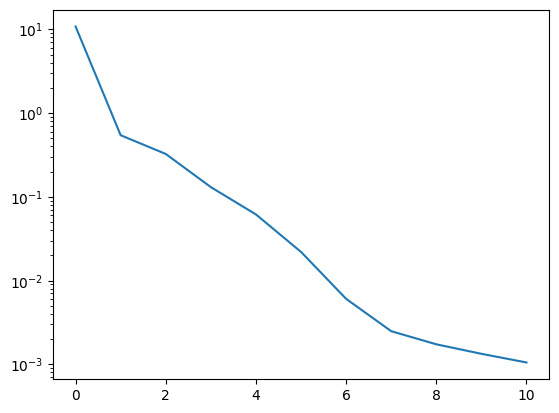

In [194]:
plt.plot(loss_hist)
plt.yscale("log")

In [195]:
def exact_sol(x, t):
    return torch.sin(torch.pi * x) * torch.exp(-t)

In [196]:
# generation of 2d grid
xs = torch.linspace(-1, 1, steps=200)
ts = torch.linspace(0, 1, steps=100)
x, t = torch.meshgrid(xs, ts, indexing='xy')

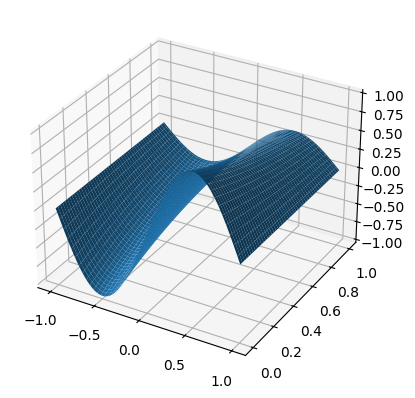

In [197]:
# plot of the exact solution to the diffusion equation
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), t.numpy(), exact_sol(x, t).numpy())
plt.show()

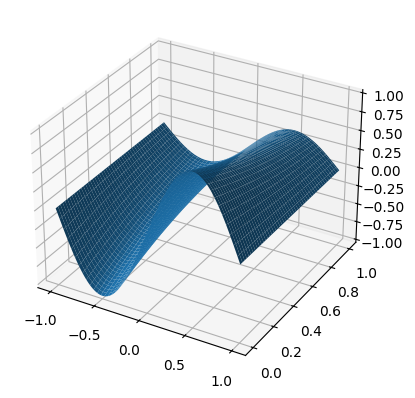

In [198]:
# plot of the exact solution to the diffusion equation
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), t.numpy(), pinn(x.flatten().unsqueeze(1), t.flatten().unsqueeze(1)).reshape(100,200).detach().numpy())
plt.show()